2019 2nd ML month with KaKR
=
> ## 목차
> 
> ### 1. 목표 및 의의   
> ### 2. 이론 [go](#3-이론)
>   > 1 Ensamble    
>   > 2 Blending    
> ### 3. 코드 분석 [go](#4-코드-분석)
>   > [1 데이터 준비 및 전처리](#1-데이터-준비-및-정제)    
>   > [2 모델 설계](#2-모델-설계)   
>   > [3 학습!](#3-학습)   
>   > [4 모델 평가](#4-모델-평가)   
> ### 4. 완벽한가? [go](#4-완벽한가)

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

# import matplotlib.pyplot as plt
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = os.getenv('HOME')+'/Working/kaggle/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
y = data['price']

del data['price']
print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [5]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [6]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 데이터 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

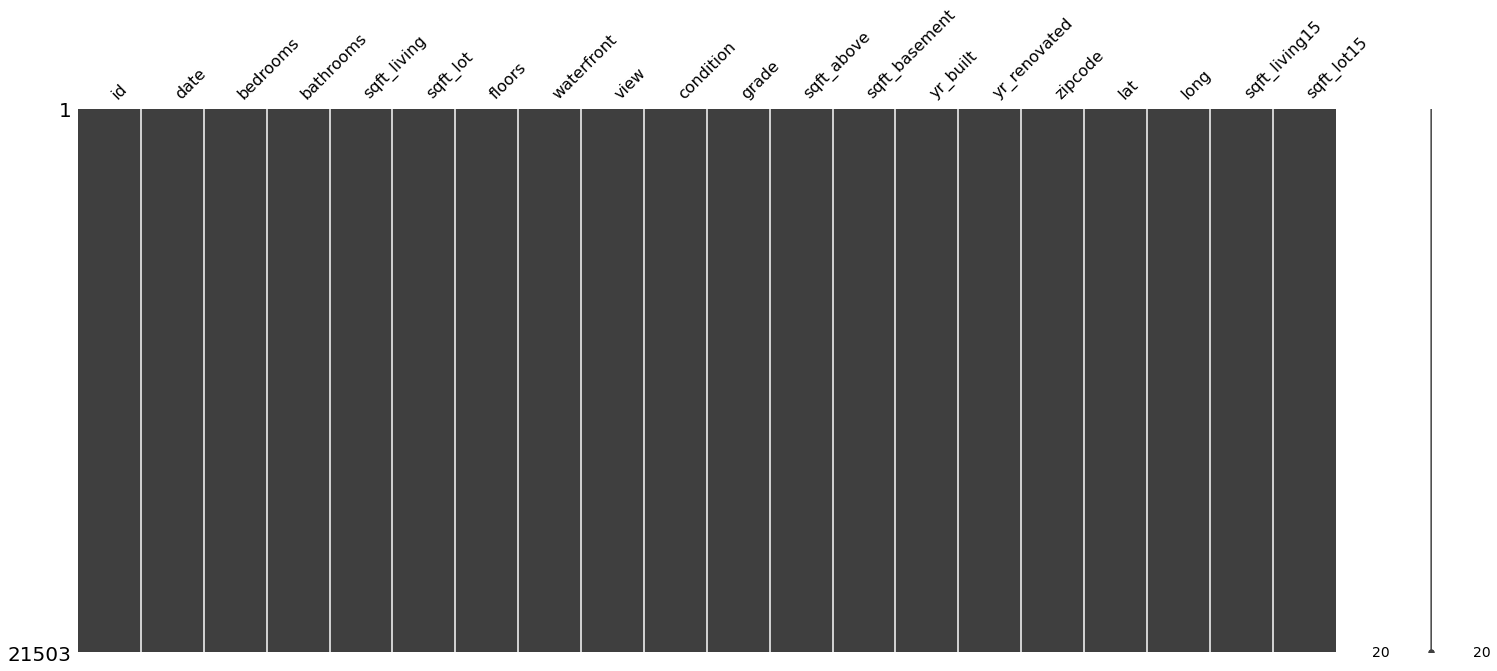

In [7]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [8]:
for c in data.columns:
    print('{} : {}'.format(c, sum(data[c].isnull())))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [9]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6]))


### 중복 index 확인
데이터를 본격적으로 시각화 하기전에, 중복되는 index가 있는지 확인하겠습니다.

In [10]:
data[data.index.duplicated()]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [11]:
len(data)

21503

In [12]:
data.index = range(len(data))
data[data.index.duplicated()]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

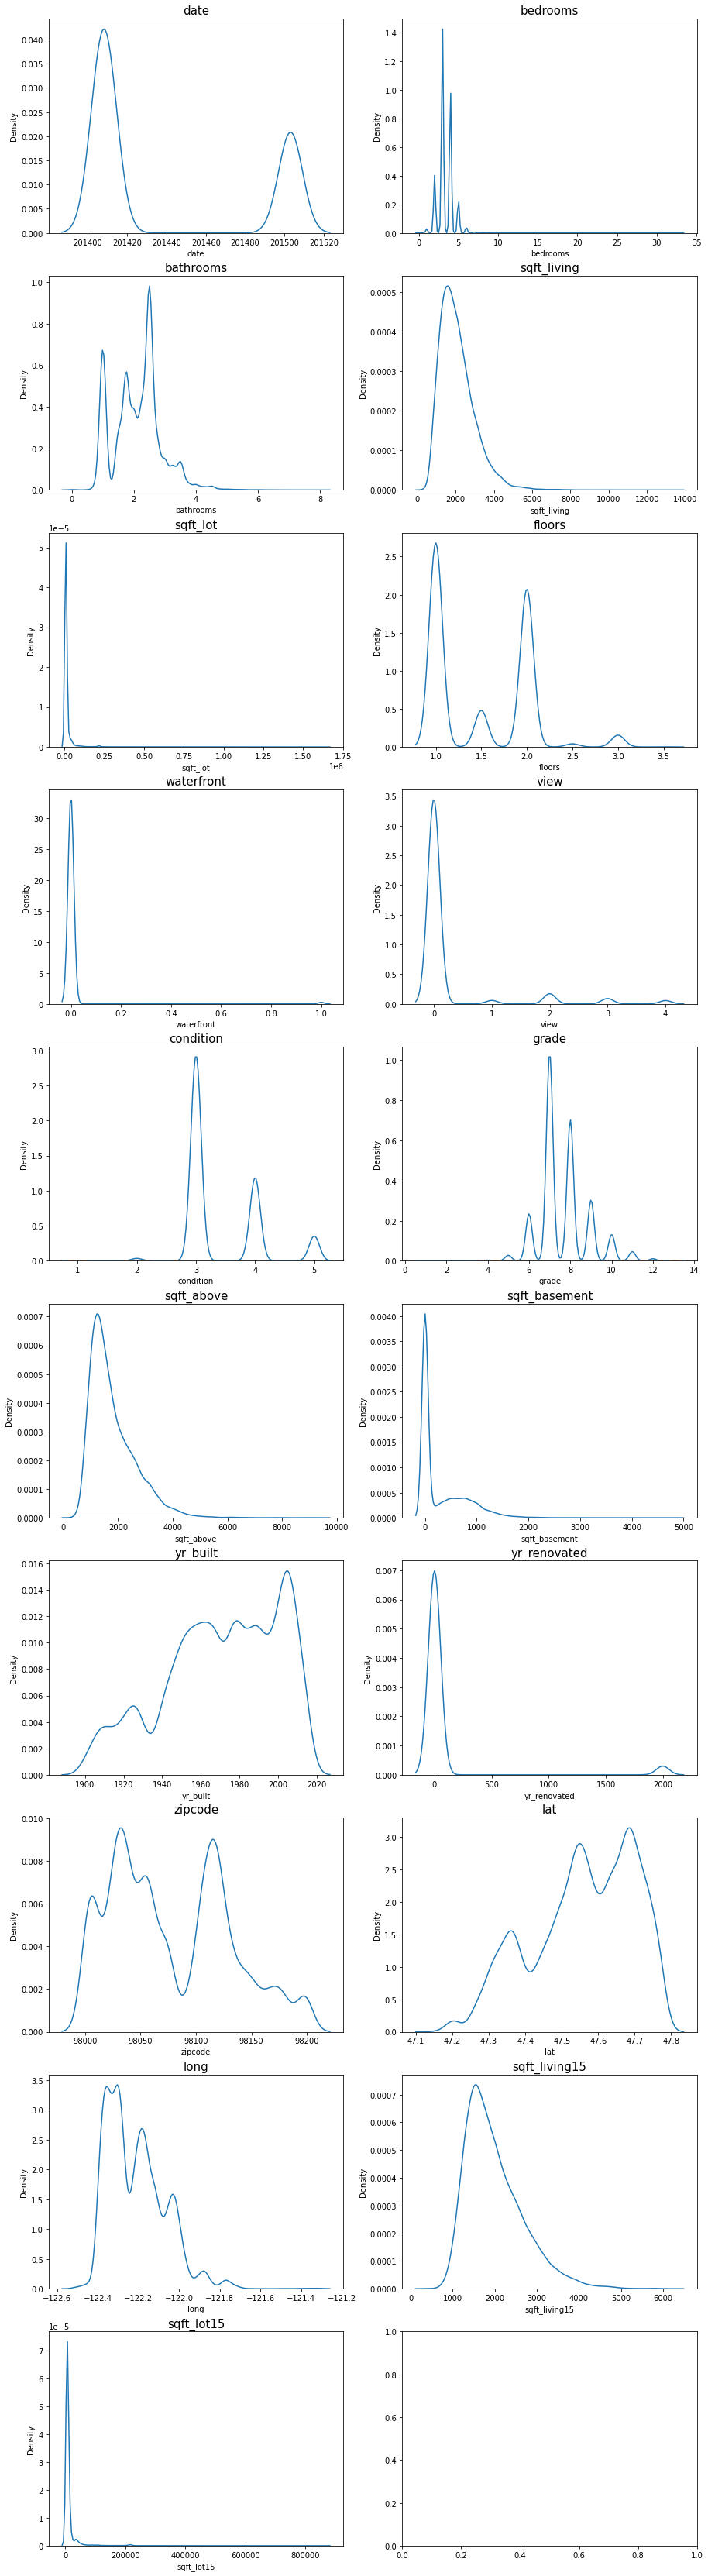

In [13]:
fig, ax = plt.subplots(10, 2, figsize=(15, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]].astype(float), ax=ax[row][col],)
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [14]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

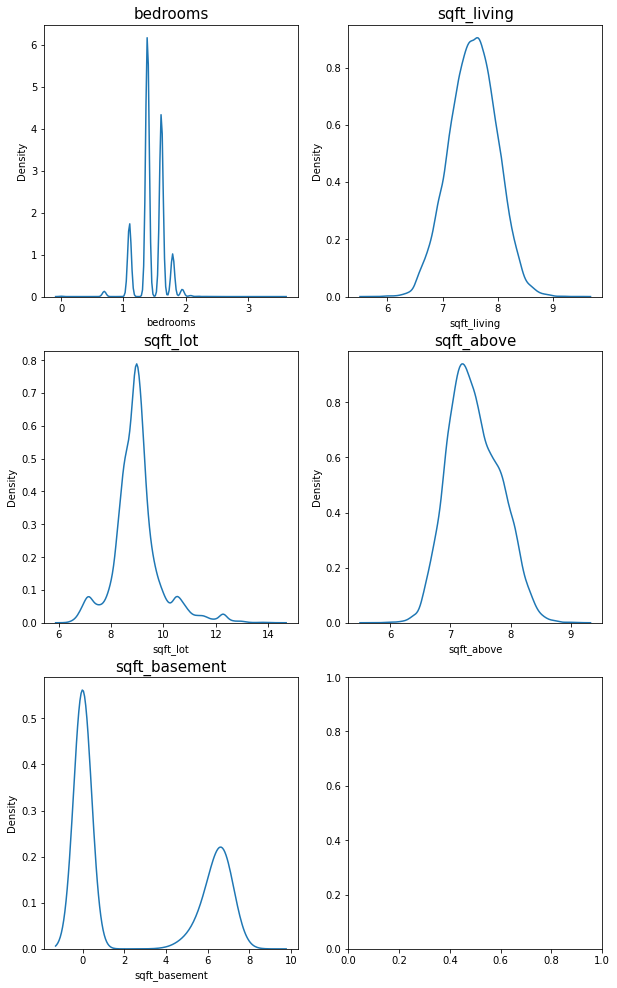

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(10, 17))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [16]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [17]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [18]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019, shuffle=True).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [19]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8597
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8819


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [20]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [21]:
y_pred = AveragingBlending(models, x, y, sub)

In [22]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})   
sub.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [23]:
sub.to_csv('submission.csv', index=False)

![firstkaggle](data/first_kaggle.png)   
첫 제출점수는 120031점이군요.   
개인적으로는 시작이 좋다는 생각이 드는 군요:)   

<br><br><br>


## 4. 리모델링
<br>

### 다시 전처리

In [3]:
data_dir = 'data/'
train_data_path = data_dir + 'train.csv'
test_data_path = data_dir + 'test.csv'

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [4]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
y = train['price']
del train['price']


In [6]:
sum_pd = pd.concat((train,test), axis = 0)

In [7]:
sum_pd['date']=sum_pd['date'].apply(lambda i: i[:6]).astype(int)
del sum_pd['id']
print(sum_pd.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

## Price값의 분포 확인

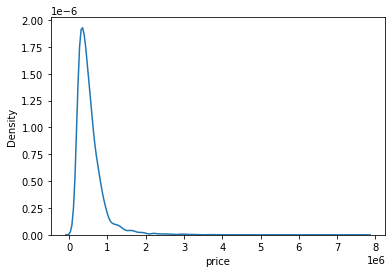

In [9]:
sns.kdeplot(y)
plt.show()


한쪽에 몰려있으면서도 넓게 펴져있군요. 직관적으로 볼 수 있도록 상용로그를 취해보겠습니다.

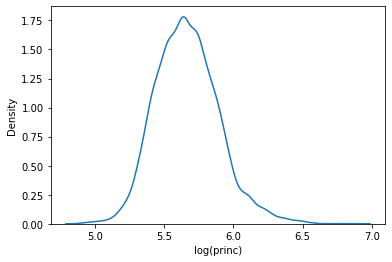

In [10]:
sns.kdeplot(np.log10(y))
plt.xlabel('log(princ)')
plt.show()

$10^{5.65}$ 정도에 모여있다는 것 정도밖에 눈에 들어오지 않는군요.. 이것만으로는 좋은 생각을 떠올리기 어려울 것 같아요!
다른 데이터와 연결지어 보겠습니다.
먼저 다른 데이터는 전부 사용 가능한 데이터인지 확인해보죠!

In [11]:
sum_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_lo

정수와, 실수값만 섞여있는 데이터입니다. 전부 사용해서 price값과의 관계를 눈으로 볼수있게 그림으로 그려볼게요!   
먼저 합쳐놨던 train, test data를 분리합니다.

In [12]:
train = sum_pd[:len(train)]
test = sum_pd[len(train):]
print('train data 수:',len(train),'test data 수:', len(test))

train data 수: 15035 test data 수: 6468


In [13]:
train.head()


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


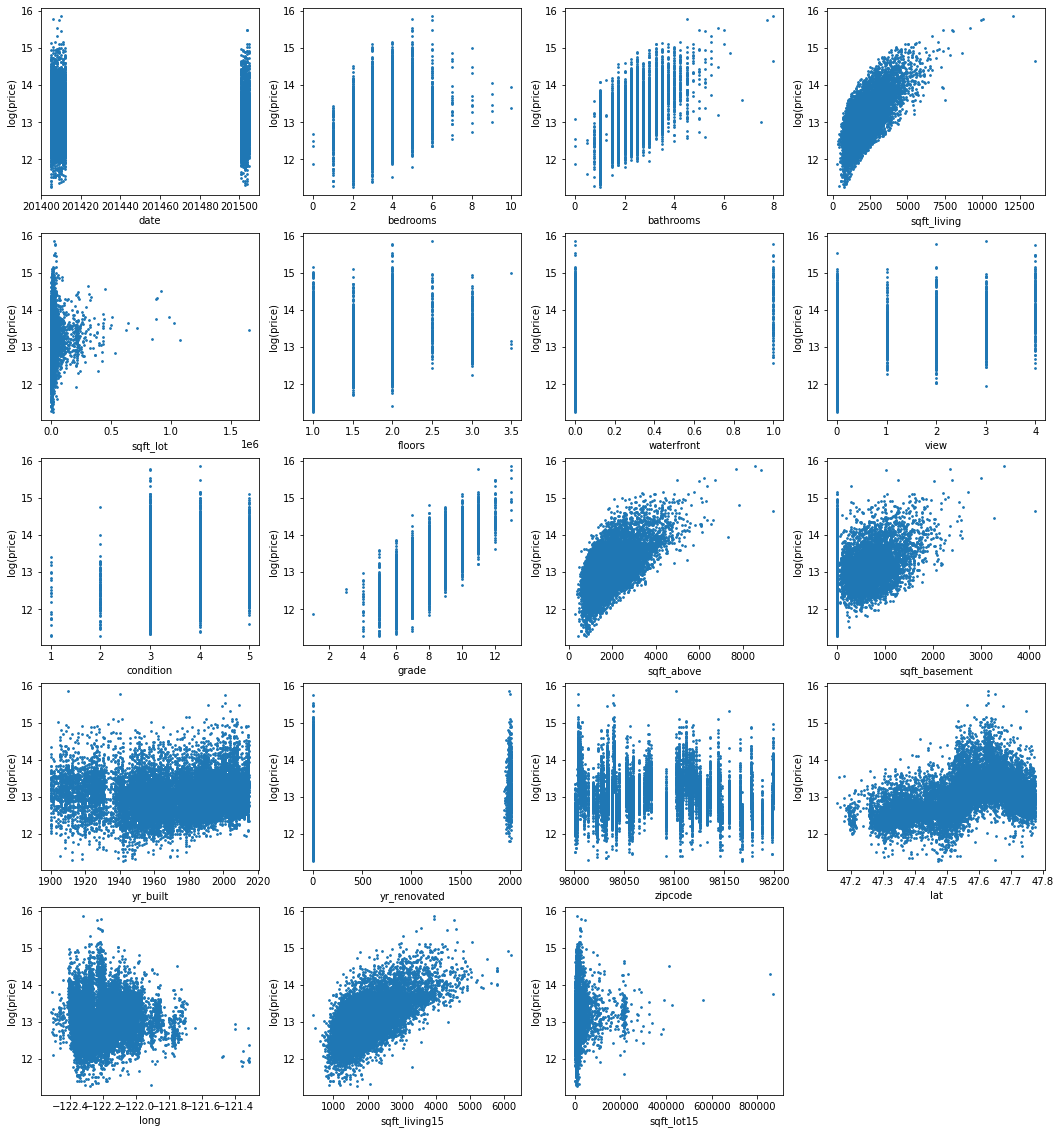

In [15]:
plt.figure(figsize=(18,20))

for i in range(19):    
    plt.subplot(5,4,i+1)
    plt.scatter(train[train.columns[i]], np.log1p(y),s=3)
    plt.xlabel(train.columns[i])
    plt.ylabel('log(price)')


그래프가 전부 어떠한 특정 개형을 갖는군요. 일단.. 전부 사용하는 것으로 해보겠습니다.
그리고 좋은 결과가 나오지 않는다면, 가격과 크게 상관관계가 없어보이는 항목은 학습에서 제외시켜보도록 하겠습니다.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [17]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [18]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [19]:
#random_state=None      # 초기값
random_state=2020       

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [20]:
gboost.__class__.__name__

'GradientBoostingRegressor'

위와 같이 모델의 이름을 출력할 수 있군요. 불필요한 식을 빼고 함수를 다시 정의해보겠습니다.
또 궁금증이 생기네요, price를 log 스케일로 학습시키는 것이 유리한 선택일까요?

In [21]:
def get_scores_logprice(models, train, y):
    # price를 log_scale로 학습시켜 RMSE score 출력
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        y_train,y_test = np.log1p(y_train), np.log1p(y_test)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(np.expm1(y_test), np.expm1(y_pred))
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

def get_scores(models, train, y):
    # price를 log_scale로 학습시켜 RMSE score 출력
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [22]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,130561.802321
RandomForestRegressor,125303.700686
LGBMRegressor,120637.379226
XGBRegressor,120062.225013


In [23]:
get_scores_logprice(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


오! 놀랍게도 log를 취해주었을때, 전체적으로 잘 예측하는 모습을 보여줍니다.
기하급수적으로 증가하는 시장가격의 무서움이 느껴지는군요..  
일단 한가지 좋은 특징을 찾았으니 바로 저희의 모델에 적용해보겠습니다.   
<br>
앞에서 정의한 AveragingBlending()을 이용하여

In [24]:
def AveragingBlending_log(models, x, y, sub_x):
    for m in models : # y에 log를 씌워 학습
        m.fit(x.values, np.log1p(y))
    
    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models
    ])
    return np.expm1(np.mean(predictions, axis=1))

y_pred = AveragingBlending_log(models, train, y, test)


In [51]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})   
sub.to_csv('submission.csv', index=False)

제출..!! 해봤는데.. 왜!! 119919점.. 
한번 직접 계산한 값과도 어느정도 일치하는지 확인해보겠습니다.

In [25]:
def Ensamble_score(models, x, y, sub_x):
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=random_state, test_size=0.2)
    y_pred = AveragingBlending_log(models,X_train, y_train, X_test)
    score = rmse(y_test,y_pred)
    return score

score = Ensamble_score(models, train, y, test)
score

112449.56209532506

### 일단 training set에서 분리한 validation set으로 평가하다보니, 점수가 더 낮은 경향이 있는 것 같습니다.   
### 또, 현재 모습으로는 그저 평균을 낸 앙상블 기법에서는 큰 이점이 없어보입니다.ㅜㅜ(점수가 XGBRegressor보다 높아요.ㅜㅜ)
### 결국, 하이퍼 파라미터를 조절해서, 모델을 변형시켜야겠습니다!

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 10, 15],
}


In [27]:

log_y = np.log1p(y)

In [61]:
grid_model = GridSearchCV(lightgbm, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, log_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10, 15],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error', verbose=1)

In [62]:
grid_model.cv_results_

{'mean_fit_time': array([0.22316041, 0.36567001, 0.49506221, 0.50356193, 0.64956217,
        1.01079512, 0.42470489, 0.78049946, 0.89366174]),
 'std_fit_time': array([0.06200162, 0.07197998, 0.10306141, 0.12120272, 0.01866654,
        0.21337904, 0.06784769, 0.10730262, 0.1879992 ]),
 'mean_score_time': array([0.02243819, 0.04666777, 0.04401026, 0.03303132, 0.07518983,
        0.09767776, 0.02583184, 0.06121173, 0.09208117]),
 'std_score_time': array([0.0117255 , 0.01258939, 0.01381825, 0.00901673, 0.03058534,
        0.04010978, 0.00212144, 0.01723378, 0.05204554]),
 'param_max_depth': masked_array(data=[1, 1, 1, 10, 10, 10, 15, 15, 15],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 150, 50, 100, 150, 50, 100, 150],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        

In [63]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 1, 'n_estimators': 150},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 150},
 {'max_depth': 15, 'n_estimators': 50},
 {'max_depth': 15, 'n_estimators': 100},
 {'max_depth': 15, 'n_estimators': 150}]

In [64]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.04842797, -0.02917734, -0.02702714,
       -0.02645818, -0.02916999, -0.02717401, -0.02660465])

In [65]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,1,150,-0.048428
3,10,50,-0.029177
4,10,100,-0.027027
5,10,150,-0.026458
6,15,50,-0.029170
7,15,100,-0.027174
8,15,150,-0.026605


In [66]:
results['RMSLE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,1,150,-0.048428,0.220064
3,10,50,-0.029177,0.170814
4,10,100,-0.027027,0.164399
5,10,150,-0.026458,0.162660
6,15,50,-0.029170,0.170792
7,15,100,-0.027174,0.164845
8,15,150,-0.026605,0.163109


In [67]:
# results = results.rename(columns={'RMSE': 'RMSLE'})
# results

results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
5,10,150,-0.026458,0.162660
8,15,150,-0.026605,0.163109
4,10,100,-0.027027,0.164399
7,15,100,-0.027174,0.164845
6,15,50,-0.029170,0.170792
3,10,50,-0.029177,0.170814
2,1,150,-0.048428,0.220064
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [28]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [37]:
# params = {
#     'n_estimators':[290,300,310,320,330],
#     'max_depth':[23,25,27]
# }
# params = {
#     'n_estimators':[50,100,200,400],
#     'max_depth':[20,30,40]
# } 이보다 수많은 실험이 있었습니다... 
params = {
    'n_estimators':[400,800],
    'max_depth':[40,60]
}

# results1 = my_GridSearch(lightgbm,train,log_y,params)
results2 = my_GridSearch(rdforest,train,log_y,params) # RandomForest는 n_estimators가 커질수록 좋아지고, 너무 무거워진다.
# results3 = my_GridSearch(gboost,train,log_y,params)
# XGBRegressor는 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .....................max_depth=40, n_estimators=400; total time= 1.8min
[CV] END .....................max_depth=40, n_estimators=400; total time= 1.8min
[CV] END .....................max_depth=40, n_estimators=400; total time= 1.8min
[CV] END .....................max_depth=40, n_estimators=400; total time= 1.8min
[CV] END .....................max_depth=40, n_estimators=400; total time= 1.9min
[CV] END .....................max_depth=40, n_estimators=800; total time= 4.8min
[CV] END .....................max_depth=40, n_estimators=800; total time= 5.1min
[CV] END .....................max_depth=40, n_estimators=800; total time= 5.1min
[CV] END .....................max_depth=40, n_estimators=800; total time= 5.5min
[CV] END .....................max_depth=40, n_estimators=800; total time= 5.4min
[CV] END .....................max_depth=60, n_estimators=400; total time= 2.6min
[CV] END .....................max_depth=60, n_est

In [78]:
results1[:10]
# model = LGBMRegressor(,,,) # max_depth는 알아서 찾고, n_estimators는 100으로 되어있었다.
# 그런면에서 상당히 의미있는 결과이다.

# model.fit(train, log_y)

,max_depth,n_estimators,score,RMSLE
1,23,300,-0.026091,0.161527
6,25,300,-0.026091,0.161527
11,27,300,-0.026091,0.161527
2,23,310,-0.026095,0.161539
7,25,310,-0.026095,0.161539
12,27,310,-0.026095,0.161539
0,23,290,-0.026103,0.161564
5,25,290,-0.026103,0.161564
10,27,290,-0.026103,0.161564
3,23,320,-0.026105,0.161572


In [38]:
results2[:10]
# model = RandomForestRegressor(,,,) max_depth = 40, n_estimators=800으로 해보겠다.
# 값이 커질수록 좋은 것 같다;; 초기값은 n_estimator = 100

,max_depth,n_estimators,score,RMSLE
3,60,800,-0.031387,0.177165
1,40,800,-0.031387,0.177165
0,40,400,-0.031481,0.177428
2,60,400,-0.031481,0.177429


In [36]:
results3[:10]
# gboost() max_depth = 5, n_estimators = 420일때 최적으로 보임!
# GradientBoostingRegressor()

,max_depth,n_estimators,score,RMSLE
1,5,420,-0.026709,0.163429
2,5,440,-0.026709,0.163430
0,5,400,-0.026716,0.163449
3,5,460,-0.026733,0.163503


### 어디 왕창 쏟아져 버린 저의 시간이 가치가 있었던 것일지 정량적으로 평가해보겠습니다.     
### 위해서 했던 각각의 RMSE score를 다시 계산해보겠습니다.

In [39]:
random_state=2020   

gboost = GradientBoostingRegressor(random_state=random_state, max_depth=5, n_estimators=420)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state, max_depth=23, n_estimators=300)
rdforest = RandomForestRegressor(random_state=random_state, max_depth=40, n_estimators=600)

models = [gboost, xgboost, lightgbm, rdforest]

In [40]:
get_scores_logprice(models, train, y)

,RMSE
RandomForestRegressor,124681.593387
XGBRegressor,110318.669566
GradientBoostingRegressor,110131.251744
LGBMRegressor,109327.604567


!! 자체 점수기는 하지만, 11만점 아래의 값이 하나가 나왔군요ㅜㅜ
RandomForestRegressor는 방해가 될 수도 있지 않을까요..? 걱정이 되니, 빼놓고 해보겠습니다. 아니 일단 포함해서 해보겠습니다!!

In [41]:
def Ensamble_score(models, x, y):
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=random_state, test_size=0.2)
    y_pred = AveragingBlending_log(models,X_train, y_train, X_test)
    score = rmse(y_test,y_pred)
    return score

score = Ensamble_score(models, train, y)
score

107709.95500874851

일단 강하게 자축을 하겠습니다..ㅜㅠ 제출했을때도 이런 점수가 유지될까 걱정이 되는군요!
걱정이 되니, 한번 RandomForest를 빼고도 점수를 보겠습니다!

In [46]:
models = [gboost, xgboost, lightgbm]
score = Ensamble_score(models, train, y)
score

105867.16251475463

어째서인지, 더 좋은 성과를 보입니다..!! 역시 포레스트는 빼고 가겠습니다!
아래 다른식은 제가 id를 날려먹어서, 불러오는 과정입니다..!

In [44]:
tst = pd.read_csv(test_data_path)
y_pred = AveragingBlending_log(models, train, y, test)
sub = pd.DataFrame(data={'id':tst['id'],'price':y_pred})   
sub.head()


,id,price
0,15035,5.034195e+05
1,15036,4.745762e+05
2,15037,1.358847e+06
3,15038,2.985546e+05
4,15039,3.334400e+05


In [45]:
sub.to_csv('submission.csv', index=False)

![image](data/4th.png)      
<br>

### 대박!!! 목표점수 달성입니다!!

### 아래함수는 다음기회에 활용해보겠습니다. :)

In [47]:
def save_submission(model, train, y, test, model_name, rmse=None):
    model.fit(train, y)
    prediction = model.predict(test)
    submission_path = 'data/sample_submission.csv'
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSE_{}.csv'.format(data_dir, model_name, rmse)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

# 4. 완벽한가?

지금까지 첫 캐글 시도를 해봤습니다. 이제야 대략적인 그림이 잡히는 것 같아요. 생각만으로도, 각 회귀모델의 세부 hiper parameter들과, 그 특성도 알고싶고, 더 많은 모델의 특성도 알 수 있으면 좋겠습니다. 또 이번에 제가 사용한 앙상블 기법도.. 사실 함수를 불러와서 사용한 느낌이 강합니다. 제가 직접 구현하기는 쉽지 않을 것 같아요. 이런 것을 제외하고도 이번 시도를 하면서 아쉬운 점은 다음과 같습니다.
<br>

> 1. 각 모델을 조금더 심도있게 공부할 필요가 있다.      
>    지금은 마구 가져다가 쓴 상황입니다. 각 변수의 의미도 모른채, 그리드 서치가 찾아준대로 썼네요;;
> 2. 데이터 전처리를 위한 노력에 비해, 한것이 없다.     
>    사실 점수가 안나오면 더 해볼 생각이었는데, 너무 빨리 도달해버렸네요. 데이터를 만져보면서, 더 도전해보고, 그 특성을 이해할 필요가 있습니다.
> 3. 랜덤서치가 더 좋다고 했는데, 그리드 서치만 사용하였다.     
>    기회를 봐서 랜덤서치도 사용해보도록 하겠습니다!        
<br>

이상으로 재미있는 첫 캐글 제출이었습니다:)